In [1]:
import random
import datetime
import numpy as np
import h5py
from skimage.filters import threshold_otsu
from skimage import io
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
import tifffile
import time
import os
import sys
import shutil
import copy
import json
from collections import Counter


import openslide
from preprocessing.datamodel import SlideManager
from preprocessing.processing import split_negative_slide, split_positive_slide, create_tumor_mask, rgb2gray
from preprocessing.util import TileMap

## Functions to shuffle test patches out of training folder

In [2]:
def move_test_case_patches(patches_dir, test_case):  
    
    # Make folder to move all test patches to. Model will not see this during training
    if os.path.exists('patches//test_patches') == False:
        os.mkdir(patches_dir + '//test_patches//')
        os.mkdir(patches_dir + '//test_patches//0//')
        os.mkdir(patches_dir + '//test_patches//1//')
    print('created folder for ' + str(test_case) + (' test patches'))

    ## Move test case 0 patches to the new folder
    for file in os.listdir(patches_dir + '//train_patches//0//'):
        if file.startswith(test_case):
            source = patches_dir + '//train_patches//0//' + file
            dest = patches_dir + '//test_patches//0//' + file
            shutil.move(source, dest) #move to designated path

    ## Move test case 1 patches to the new folder
    for file in os.listdir(patches_dir + '//train_patches//1//'):
        if file.startswith(test_case):
            source = patches_dir + '//train_patches//1//' + file
            dest = patches_dir + '//test_patches//1//' + file
            shutil.move(source, dest) #move to designated path

    print('files for test case ' + str(test_case) + ' all moved, ready to train')   

In [3]:
def reset_patches(patches_dir, test_case):
    ## Move files back to patches//all folder
    for file in os.listdir(patches_dir + '//test_patches//0//'):
        if file.startswith(test_case):
            source = patches_dir + '//test_patches//0//' + file
            dest = patches_dir + '//train_patches//0//' + file
            shutil.move(source, dest) #move to designated path

    for file in os.listdir(patches_dir + 'test_patches//1//'):
        if file.startswith(test_case):
            source = patches_dir + '//test_patches//1//' + file
            dest = patches_dir + '//train_patches//1//' + file
            shutil.move(source, dest) #move to designated path
            
    ## Make sure test case folder is empty before deleting directory
    if len(os.listdir(patches_dir + 'test_patches//0//')) == 0 and len(os.listdir(patches_dir + 'test_patches//1//')) == 0:
        print('deleting directory test_patches//')
        os.rmdir(data_dir + 'test_patches//0')
        os.rmdir(data_dir +'test_patches//1')
        os.rmdir(data_dir +'test_patches')
    else:
        print('test patch directory is not empty, not deleting')

## Define training parameters

In [4]:
## Define parameters
# Define directory and slide manager
DIR = ''
mgr = SlideManager(cam16_dir=DIR)

# Get annotated slides
slides_met = mgr.met_slides
N_met = len(slides_met)
print('Number of annotated slides:', N_met)

# Get normal slides
slides_negative = mgr.negative_slides
N_negative = len(slides_negative)
print('Number of normal slides:', N_negative)

data_dir = 'patches//'

model_name = "resnet" #"resnet"

# Number of classes in the dataset
num_classes = 2

batch_size = 64

input_size = 512

# Number of epchs to train for
num_epochs = 20

feature_extract = False

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Number of annotated slides: 2
Number of normal slides: 2


In [15]:
#train_model function handles training and validation of a given model
#inputs: PyTorch model, dictionary of dataloaders, loss function, optimizer,
#number of epochs to train/validate for
#during training, it keeps track of best performing model in terms of validation
#accuracy. at the end, it returns the best performing model

def train_model(model, fold, dataloaders_train, criterion, optimizer, num_epochs):
    since = time.time()
    phase = 'train'

    train_loss_history = []
    val_loss_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        ## Initialize variables
        all_labels = None
        all_outputs = None
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        model.train()  # Set model to training mode
        dataloaders = dataloaders_train['train_patches']
        
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        ii = 0
        for inputs, labels in dataloaders: #get inputs. data is list of [inputs, labels]
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                # Get model outputs and calculate loss
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                positive_predictions = np.where(preds.cpu().detach().numpy() == 1)
                negative_predictions = np.where(preds.cpu().detach().numpy() == 0)

                labels_cpu = labels.cpu().detach().numpy()
                preds_cpu = preds.cpu().detach().numpy()
                N_preds = len(labels_cpu)
                N_1 = sum(labels_cpu)
                N_0 = N_preds - N_1
                N_correct = len(np.where(labels_cpu == preds_cpu)[0])

                if all_outputs is None:
                    all_outputs = outputs.cpu().detach().numpy()
                    all_labels = labels_cpu
                else:
                    all_outputs = np.append(all_outputs, outputs.cpu().detach().numpy(), axis = 0)
                    all_labels = np.append(all_labels, labels_cpu)

                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            ii += 1

        epoch_loss = running_loss / (ii*batch_size) #len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / (ii*batch_size) #len(dataloaders[phase].dataset)
        train_loss_history.append(epoch_loss)
        
        ## Save models across all epochs
#         torch.save(model, 'model for fold ' + str(fold) + ', epoch ' + str(epoch) + '.pt') 
        print('epoch loss = ' + str(epoch_loss))

    plt.figure
    plt.plot(train_loss_history,'b')
    plt.show()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return model, train_loss_history, all_outputs, all_labels

In [16]:
# When feature extracting, we only want to update parameters of last layer
# Therefore, do not need to compute gradients for the rest of model
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [17]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        ## Add dropout layer
        model_ft.fc = nn.Sequential(nn.Dropout(0.5),nn.Linear(num_ftrs, 2))
        input_size = 512 #256# 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 256 #224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 256 #224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Print the model we just instantiated
# print(model_ft)

In [18]:
#Find number of files in train//0//
path = data_dir + '//train_patches//0//'
N_0 = 0
for file in os.listdir(path):
    if file.endswith('.tif'):
        N_0 += 1

print('Number of patches in metaplasia-negative training set: ' + str(N_0))

#Find number of files in train//1//
N_1 = 0
path = data_dir + '//train_patches//1//'
for file in os.listdir(path):
    if file.endswith('.tif'):
        N_1 += 1
print('Number of patches in metaplasia-positive training set: ' + str(N_1))

Number of patches in metaplasia-negative training set: 244
Number of patches in metaplasia-positive training set: 181


## Identify cases and set up transforms

In [19]:
path = data_dir + '//train_patches//'

## Get list of case names and class (0 or 1) for all patches
cases = []

dataset = datasets.ImageFolder(root = path)
for i in range(len(dataset.imgs)):
    patch_name = dataset.imgs[i][0].split('\\') ## Grab file name of the patch
    patch_case = patch_name[1].split('_')[0] ## Grab case name from file name - relies on "case##_" format

    if patch_case not in cases:
        cases.append(patch_case)

N_cases = len(cases)

In [20]:
data_transforms = {
    'train_patches': transforms.Compose([
        transforms.RandomRotation(degrees=(0, 180)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomResizedCrop(input_size),
        transforms.ColorJitter(hue = 0.25),
        transforms.ColorJitter(brightness = 0.4),
        transforms.ColorJitter(contrast = 0.40),
        transforms.ColorJitter(saturation = 0.10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

## Train model

test case is case00
created folder for case00 test patches
files for test case case00 all moved, ready to train
N_0 = 110
N_1 = 70
test case = case00
dataloaders_train = {'train_patches': <torch.utils.data.dataloader.DataLoader object at 0x000001DF8C09DA20>}
Epoch 0/19
epoch loss = 0.7797203709681829
Epoch 1/19
epoch loss = 0.6385753800471624
Epoch 2/19
epoch loss = 0.4930993740757306
Epoch 3/19
epoch loss = 0.3975772752116124
Epoch 4/19
epoch loss = 0.3854825732608636
Epoch 5/19
epoch loss = 0.33164975481728715
Epoch 6/19
epoch loss = 0.27949355728924274
Epoch 7/19
epoch loss = 0.2386741548155745
Epoch 8/19
epoch loss = 0.21900592744350433
Epoch 9/19
epoch loss = 0.20999584533274174
Epoch 10/19
epoch loss = 0.22220958955585957
Epoch 11/19
epoch loss = 0.13023654526720443
Epoch 12/19
epoch loss = 0.1341610069697102
Epoch 13/19
epoch loss = 0.1077622314915061
Epoch 14/19
epoch loss = 0.1643722246711453
Epoch 15/19
epoch loss = 0.14621113644291958
Epoch 16/19
epoch loss = 0.0956755811348

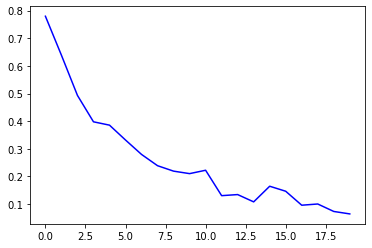

Training complete in 4m 4s
GPU memory used = 11.572150784
deleting directory test_patches//
image patch locations have been reset

test case is case01
created folder for case01 test patches
files for test case case01 all moved, ready to train
N_0 = 134
N_1 = 111
test case = case01
dataloaders_train = {'train_patches': <torch.utils.data.dataloader.DataLoader object at 0x000001DF8D68C780>}
Epoch 0/19
epoch loss = 0.7052892874926329
Epoch 1/19
epoch loss = 0.642664851155132
Epoch 2/19
epoch loss = 0.5885129522066563
Epoch 3/19
epoch loss = 0.4829393606632948
Epoch 4/19
epoch loss = 0.4198697723913938
Epoch 5/19
epoch loss = 0.388317282195203
Epoch 6/19
epoch loss = 0.3567520307842642
Epoch 7/19
epoch loss = 0.43376960896421224
Epoch 8/19
epoch loss = 0.34454586647916585
Epoch 9/19
epoch loss = 0.3069106239126995
Epoch 10/19
epoch loss = 0.30206949345301837
Epoch 11/19
epoch loss = 0.3215226230677217
Epoch 12/19
epoch loss = 0.30811946536414325
Epoch 13/19
epoch loss = 0.23863690625876188


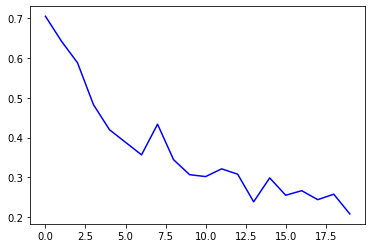

Training complete in 4m 42s
GPU memory used = 12.10797312
deleting directory test_patches//
image patch locations have been reset



In [21]:
fold = 0
for test_case in cases:
    print('test case is ' + str(test_case))

    ### Move patches that correspond to testing case to a new folder (these patches will not be used for training)
    move_test_case_patches(data_dir, test_case)

    # Initialize the model for this run
    model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

    ## Create optimizer
    model_ft = model_ft.to(device) ## Send model to GPU
    params_to_update = model_ft.parameters()
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
    else:
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                pass

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

    ## Get training ID's for this particular fold
    train_idx = []
    train_class = []
    train_case_0 = []
    train_case_1 = []

    ## All patches within this loop are train patches
    train_dataset = datasets.ImageFolder(root = 'patches//train_patches//')

    for i in range(len(train_dataset.imgs)): #Go through all dataset patches
        patch_name = train_dataset.imgs[i][0].split('\\') ## Grab file name of the patch
        patch_case = patch_name[1].split('_')[0] ## Grab case name from file name - relies on "case_" format
        patch_class = train_dataset.imgs[i][1] ## Grab class of the patch (0 or 1)

        ## If patch is within training dataset (i.e. not from testing case)
        if patch_case not in test_case:
            train_idx.append(i)
            train_class.append(patch_class)
            if patch_class == 0:
                train_case_0.append(patch_case) #Append the case to list of negative training patches
            if patch_class == 1:
                train_case_1.append(patch_case) #Append the case to list of negative training patches

        ## If specific patch belongs to case we are testing on, then a patch has not been correctly moved to test folder
        if patch_case in test_case:
            print('ERROR - check that test patches are not in training folder')

    ## Count how many patches correspond to each case for 0 and 1. Depends on case names being unique in the list (check this manually)
    counts_0 = Counter(train_case_0) 
    counts_1 = Counter(train_case_1)

    N_0 = len(train_case_0) #Number of zero patches in training cases
    N_1 = len(train_case_1 )#Number of one patches in training cases 
    print('N_0 = ' + str(N_0))
    print('N_1 = ' + str(N_1))

    ## Create weighted sampler for patches
    ## During training, positive patches will be loaded just as frequently as negative patches to avoid bias from imbalanced datasets
    weights_train = []
    for i in range(len(train_dataset.imgs)):
        if i in train_idx:
            patch_name = train_dataset.imgs[i][0].split('\\') ## Grab file name of the patch
            patch_case = patch_name[1].split('_')[0] ## Grab case name from file name - relies on "case##_" format
            patch_class = train_dataset.imgs[i][1] ## Grab class of the patch (0 or 1)

            if patch_class == 0:
                weight = (1/counts_0[patch_case])/(N_0+N_1)
                weights_train.append(weight)
            if patch_class == 1:
                weight = 2*(1/counts_1[patch_case])/(N_0+N_1)
                weights_train.append(weight)

    train_sampler = torch.utils.data.sampler.WeightedRandomSampler(weights_train, len(train_dataset), replacement = True)

    ## Define dataloaders for downsampled training session
#     train_image_datasets = {datasets.ImageFolder(data_dir, data_transforms)}
    train_image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train_patches']}
    dataloaders_train = {x: torch.utils.data.DataLoader(train_image_datasets[x], batch_size = batch_size, sampler = train_sampler, num_workers=4) for x in ['train_patches']}

    print('test case = ' + str(test_case))
    print('dataloaders_train = ' + str(dataloaders_train))
    
    # Train and evaluate
    model_ft, train_loss_history, all_outputs, all_labels  = train_model(model_ft, fold, dataloaders_train, criterion, optimizer_ft, num_epochs)
    print('GPU memory used = ' + str((torch.cuda.memory_reserved() + torch.cuda.memory_allocated())/(1e9)))

    # Save model for this fold
    PATH = 'resnet_gitest_' + str(fold) + '_' + str(test_case) + '.pt'
    if os.path.isfile(PATH) == True:
        print('Model has already been saved to this name. Not over-writing')
    else:
        torch.save(model_ft, PATH)  

    ## Delete variables to clear memory and ensure that learned parameters do not leak between folds
    del model_ft, train_loss_history, all_outputs, all_labels, optimizer_ft, params_to_update, 

    ## Reset all test patches
    reset_patches(data_dir, test_case)
        
    print('image patch locations have been reset')
    print('')
    torch.cuda.empty_cache()
    fold += 1